# CandyCare

__PML WS 2021/22__ <br>
_by Julian Mierisch and Anna Martynova_

### Goals
1. Make Model which predicts which win percentage a given new candy has
2. Predict which combination has highest win propability
3. Cluster data?

### Import packages and data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns

In [2]:
candyDataAll = pd.read_csv('candy-data.csv')
candyDataAll

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


## Data exploration 
### Inspect distribution of candy attributes in dataset

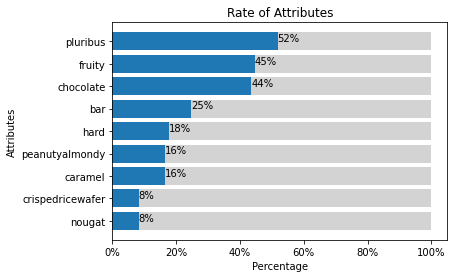

In [3]:
#Show distribution of candy attributes in dataset
candyAttributes = candyDataAll.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
data = {'Attributes': candyAttributes.columns, 'Values': candyAttributes.sum()/len(candyAttributes)}  
candyAttrPercent = pd.DataFrame(data).reset_index().drop(columns=['index']).sort_values(by=['Values'])

fig, ax = plt.subplots()
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1]/2,y_list[i-1], ha="center")
plt.barh(candyAttrPercent['Attributes'], candyAttrPercent['Values'])
for index, value in enumerate(candyAttrPercent['Values']):
    plt.text(value, index, str("{:.0%}".format(value)))
plt.barh(candyAttrPercent['Attributes'], 1-candyAttrPercent['Values'], left=candyAttrPercent['Values'], color="lightgrey")
plt.title('Rate of Attributes')
plt.ylabel('Attributes')
plt.xlabel('Percentage')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.show()

### Inspect feature distribution

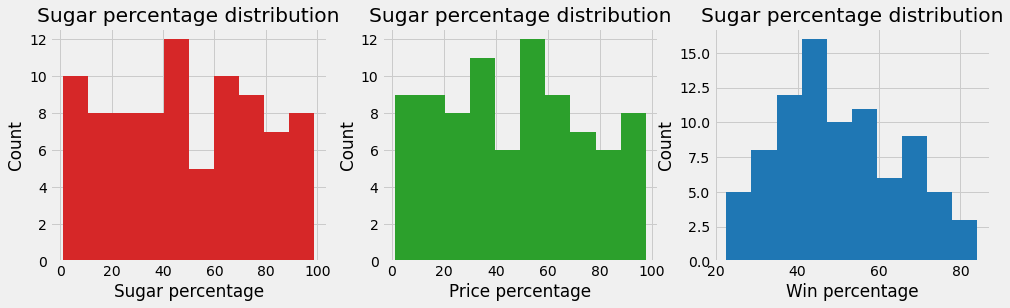

In [65]:
# Feature distribution
sugar = candyDataAll['sugarpercent']*100
price = candyDataAll['pricepercent']*100
win = candyDataAll['winpercent']
colors = ['tab:red', 'tab:green', 'tab:blue']
data = [sugar, price, win]
titles = ['Sugar percentage distribution','Price percentage distribution','Win percentage distribution']
labels = ['Sugar percentage','Price percentage','Win percentage']

fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)

for i in range(3):
    ax[i].hist(data[i], bins=10, color=colors[i])
    ax[i].title.set_text('Sugar percentage distribution')
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel('Count')

## Cluster Analysis
### Detect suitable cluster amount

C:\Users\annma\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


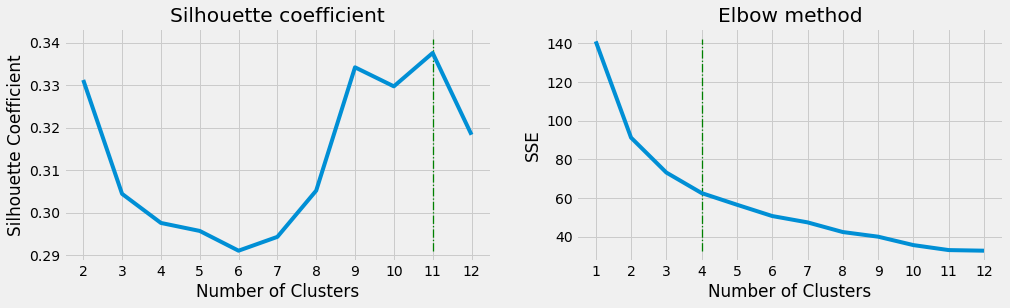

The optimal cluster amount based on silhouette coefficient method is  11
The optimal cluster amount based on elbow method is  4


In [104]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
# conda install -c conda-forge kneed

kmeans = KMeans(n_clusters = 2)
candyData = candyDataAll.drop(columns=['winpercent','competitorname'])

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

# https://realpython.com/k-means-clustering-python/#:~:text=The%20k%2Dmeans%20clustering%20method,data%20objects%20in%20a%20dataset.&text=These%20traits%20make%20implementing%20k,novice%20programmers%20and%20data%20scientists.
# to choose the appropriate number of clusters:
# silhouette coefficient = measure of cluster cohesion and separation
# values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters

silhouette_coefficients = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(candyData)
    score = silhouette_score(candyData, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
ax[0].set_title("Silhouette coefficient")
ax[0].plot(range(2, 13), silhouette_coefficients)
ax[0].set_xticks(range(2, 13))
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("Silhouette Coefficient")
ax[0].vlines(silhouette_coefficients.index(max(silhouette_coefficients))+2, ymin=min(silhouette_coefficients), ymax=1.01*max(silhouette_coefficients), colors='green', linestyles='dashdot', linewidth=1.3)


# to choose the appropriate number of clusters:
# elbow = measure of cluster cohesion and separation

sse = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(candyData)
    sse.append(kmeans.inertia_)
ax[1].set_title("Elbow method")
ax[1].plot(range(1, 13), sse)
ax[1].set_xticks(range(1, 13))
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("SSE")
kl = KneeLocator(
    range(1, 13), sse, curve="convex", direction="decreasing")
ax[1].vlines(kl.elbow, ymin=min(sse), ymax=max(sse)*1.01, colors='green', linestyles='dashdot', linewidth=1.3)

plt.show()
print("The optimal cluster amount based on silhouette coefficient method is ", silhouette_coefficients.index(max(silhouette_coefficients))+2)
print("The optimal cluster amount based on elbow method is ", kl.elbow)



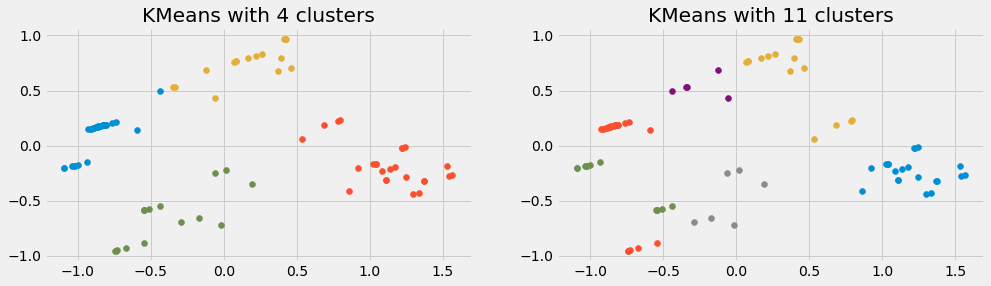

In [113]:
pca = PCA(2)
cD = pca.fit_transform(candyData)

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

kmeansE = KMeans(n_clusters=kl.elbow)
label = kmeansE.fit_predict(cD)
u_labels = np.unique(label)
for i in u_labels:
    ax[0].scatter(cD[label == i, 0], cD[label == i, 1], label = i)
ax[0].set_title("KMeans with " + str(kl.elbow) + " clusters")
#ax[0].legend()


kmeansS = KMeans(n_clusters=silhouette_coefficients.index(max(silhouette_coefficients))+2)
label = kmeansS.fit_predict(cD)
u_labels = np.unique(label)
for i in u_labels:
    ax[1].scatter(cD[label == i, 0], cD[label == i, 1], label = i)
ax[1].set_title("KMeans with " + str(silhouette_coefficients.index(max(silhouette_coefficients))+2) + " clusters")
#ax[1].legend()
plt.show()